In [2]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import math as m
#scipy.optimize.fsolve
import scipy as sp

## Question 1 orbit propagation

Q1 a cartesian

In [15]:
"""
Q1 a: convert to cartesian
"""
mu = 398600.
a = 7000.
e = 0.05
i = np.deg2rad(35.) #inclination
omega = np.deg2rad(100.) #RAAN
w = np.deg2rad(30.) #argument of periapsis
M = np.deg2rad(0.) #radians

#code taken from HW2
#Find eccentric anomaly E using M and e
#I love newton's method!
E0 = M
g = 1
itr = 0 #iteration counter
tol = 1e-10
print("Newton's Method:")
while(abs(g) > tol): #see Lecture 4 page 18
# for i in range(4):
    g = E0-e*np.sin(E0) - M
    dg_dE = 1-e*np.cos(E0) #derivative dg over dE
    E1 = E0 - g/dg_dE
    print(itr,g,E1)
    E0 = E1 #update E0 as E1
    itr = itr+1
print(f"Eccentric Anomaly after Newton's Method: {E1}")

#true anomaly
#lecture 4 page 18
f = 2*np.arctan2( np.sqrt(1+e)*np.tan(E0/2), np.sqrt(1-e))
print(f"f = {f}")

#angular momentum known a, e, mu
h = np.sqrt(mu*a*(1-e**2))
print(f"h = {h}")

#theta
theta = w + f
print(f"theta = {theta}")

#r_mag
r_mag = a*(1-e**2) / (1+e*np.cos(f))
print(f"r_mag = {r_mag}")

#r_vec
#lecture 5 page 9
e_hat_r = np.array([np.cos(theta)*np.cos(omega) - np.cos(i)*np.sin(omega)*np.sin(theta), 
                    np.cos(theta)*np.sin(omega) + np.cos(i)*np.cos(omega)*np.sin(theta), 
                    np.sin(i)*np.sin(theta)])
r0 = r_mag*e_hat_r
print(f"Q1.1 r0 = {repr(r0)}")

#v
v0 = np.array([
    -mu/h*( np.cos(omega)*(np.sin(theta) + e*np.sin(w)) + np.sin(omega)*(np.cos(theta) + e*np.cos(w))*np.cos(i) ),
    -mu/h*( np.sin(omega)*(np.sin(theta) + e*np.sin(w)) - np.cos(omega)*(np.cos(theta) + e*np.cos(w))*np.cos(i) ),
    mu/h*( (np.cos(theta) + e*np.cos(w))*np.sin(i))
])
print(f"Q1.2 v0 = {repr(v0)}")
#end of old code

R = 6378. #km
J2 = 0.00108263
p0 = 3/2*(J2*mu*R**2)/r_mag**4 * np.array([r0[0]/r_mag*( 5*(r0[2]/r_mag)**2 - 1 ), r0[1]/r_mag*( 5*(r0[2]/r_mag)**2 - 1 ), r0[2]/r_mag*( 5*(r0[2]/r_mag)**2 - 3 )])
print(f"Q1.3 initial perturb accel p0 = {p0}")

Newton's Method:
0 0.0 0.0
Eccentric Anomaly after Newton's Method: 0.0
f = 0.0
h = 52756.274508346396
theta = 0.5235987755982988
r_mag = 6650.0
Q1.1 r0 = array([-3682.35354532,  5198.61357391,  1907.14165087])
Q1.2 v0 = array([-4.85361623, -4.88365245,  3.94070938])
Q1.3 initial perturb accel p0 = [ 4.38970266e-06 -6.19722347e-06 -9.99642217e-06]


Q1 b numerically

In [68]:
"""
1b: Propaganate numerically
"""
#10 orbit periods
T = np.sqrt(4*np.pi**2*a**3/mu) #kepler's 3rd: period of initial orbit

#https://danielmuellerkomorowska.com/2021/02/16/differential-equations-with-scipy-odeint-or-solve_ivp/
def eom_twobody(t,u, mu, R):
    """
    params:
    ---------------------
    t: float, timestep
    u: 1D array, position is first 3 elements and velocity is last 3 elements

    returns:
    udot: 1D array of same dimension as u
    """
    udot = np.zeros_like(u) #v, a
    r_eom = u[0:3]
    r_mag_eom = np.linalg.norm(r_eom)
    pJ2 = 3/2*(J2*mu*R**2)/r_mag_eom**4 * np.array([u[0]/r_mag_eom*( 5*(u[2]/r_mag_eom)**2 - 1 ), u[1]/r_mag_eom*( 5*(u[2]/r_mag_eom)**2 - 1 ), u[2]/r_mag_eom*( 5*(u[2]/r_mag_eom)**2 - 3 )])
    a_earth = -mu*r_eom/(r_mag_eom**3) #acceleration from earth
    pJ2 += a_earth
    udot[0] = u[3] #lazy, just do this
    udot[1] = u[4]
    udot[2] = u[5]
    udot[3] = pJ2[0]
    udot[4] = pJ2[1]
    udot[5] = pJ2[2]
    return udot

t_span = (0.0, T*10.)
# t = np.arange(0.0, T*10., 0.1) #dt = 1 second
# print(np.append(r0,v0))
solution = sp.integrate.solve_ivp(eom_twobody, t_span, np.append(r0,v0), args=(mu, R), method='RK45', rtol=1e-10, atol = 1e-10)
u = solution.y
t_actual = solution.t
u_10 = u[:,-1]
r_10 = u_10[0:3]
v_10 = u_10[3:6]
print("Assuming radius of earth = 6378 km")
print(f"Q1.4 r_10 = {r_10} km")
print(f"Q1.5 v_10 = {v_10} km/s")

Assuming radius of earth = 6378 km
Q1.4 r_10 = [-4045.76001192  4662.34695339  2475.78284879] km
Q1.5 v_10 = [-4.39644107 -5.61518143  3.47140282] km/s


1c plot

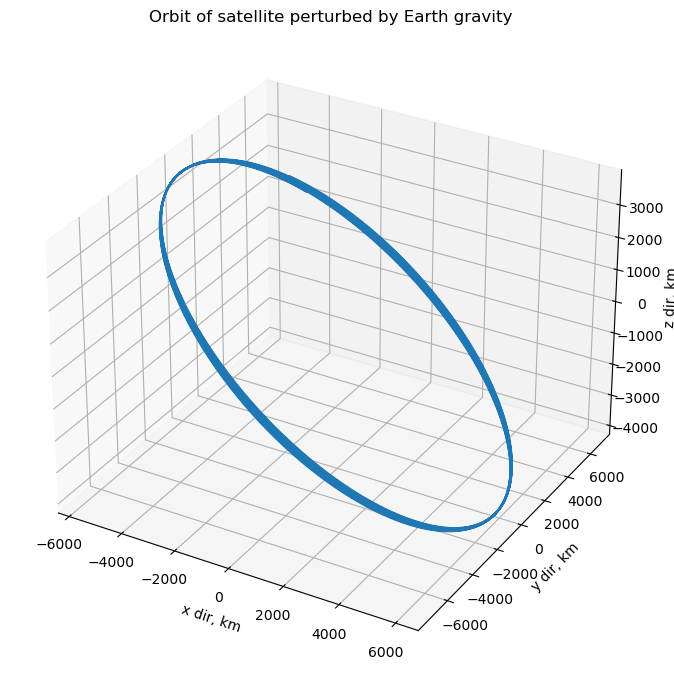

In [103]:
fig = plt.figure(figsize=(10,8)) 
ax = fig.add_subplot(111, projection='3d') 
ax.plot(u[0],u[1],u[2])
ax.set_xlabel("x dir, km")
ax.set_ylabel("y dir, km")
ax.set_zlabel("z dir, km")
ax.set_title("Orbit of satellite perturbed by Earth gravity")
fig.tight_layout(pad=5.0)
plt.savefig("hw4_1_6.jpg", dpi = 300)
plt.show()

1d orbit elements

In [174]:
#reverse orbit calculation from HW2
def cartesian_to_elements(r, v, mu):
    r_mag = np.linalg.norm(r)
    v_mag = np.linalg.norm(v)
    a = 1/(2/r_mag - v_mag**2/mu)
    e_vec = (v_mag**2/mu - 1/r_mag)*r - 1/mu*np.dot(r,v)*v
    e = np.linalg.norm(e_vec)
    h_vec = np.cross(r, v)
    h = np.linalg.norm(h_vec)
    
    I = np.array([1.,0,0])
    J = np.array([0,1.,0])
    K = np.array([0,0,1.])
    
    i = np.arccos(np.dot(h_vec/h,K)) #inclination
    if i<0 or i>np.pi: #thanks Galen
        print('oh fuck you piece of shit')
    n = np.cross(K,h_vec/h)
    n_mag = np.linalg.norm(n)
    omega = np.arccos(np.dot(n,I)/n_mag)
    if np.dot(n,J) < 0: #due to stupid cosine issues
        omega = 2*np.pi - omega
    w = np.arccos(np.dot(n,e_vec)/(n_mag*e))
    if np.dot(e_vec, K) < 0: #due to stupid cosine issues
        w = 2*np.pi - w
    f = np.arccos(np.dot(e_vec,r)/(e*r_mag))

    return a,e,i,omega,w,f


a_10, e_10, i_10, omega_10, w_10,f_10 = cartesian_to_elements(r_10,v_10,mu)
print(f"a_10 = {a_10}")
print(f"e_10 = {e_10}")
print(f"i_10 = {np.degrees(i_10)}")
print(f"omega_10 = {np.degrees(omega_10)}")
print(f"w_10 = {np.degrees(w_10)}")

a_list = []
e_list = []
i_list = []
omega_list = []
w_list = []

for i in range(len(u[0])):
    r_i = np.array([u[0][i], u[1][i], u[2][i]])
    v_i = np.array([u[3][i], u[4][i], u[5][i]])
    # print("fuck")
    a_i,e_i,i_i,omega_i,w_i,f_i = cartesian_to_elements(r_i,v_i,mu)
    # print("fucker")
    a_list.append(a_i)
    e_list.append(e_i)
    i_list.append(i_i)
    omega_list.append(omega_i)
    w_list.append(w_i)

a_10 = 6998.758584546468
e_10 = 0.04984172373508771
i_10 = 34.993390826161324
omega_10 = 95.99542952845664
w_10 = 35.86023044723879


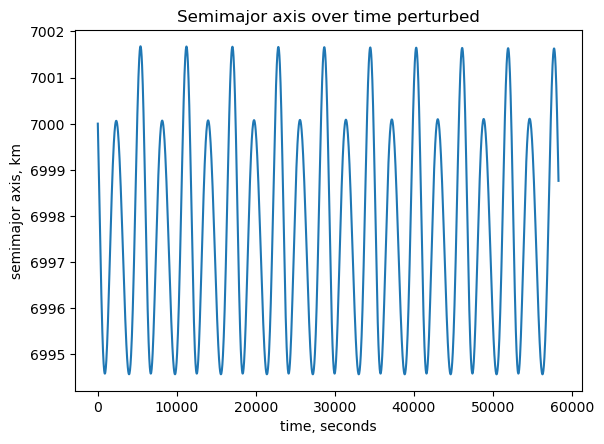

In [172]:
plt.plot(t_actual,a_list)
plt.xlabel("time, seconds")
plt.ylabel("semimajor axis, km")
plt.title("Semimajor axis over time perturbed")
plt.tight_layout(pad=2.0)
plt.savefig("hw4_1_12_a.jpg", dpi = 300)
plt.show()

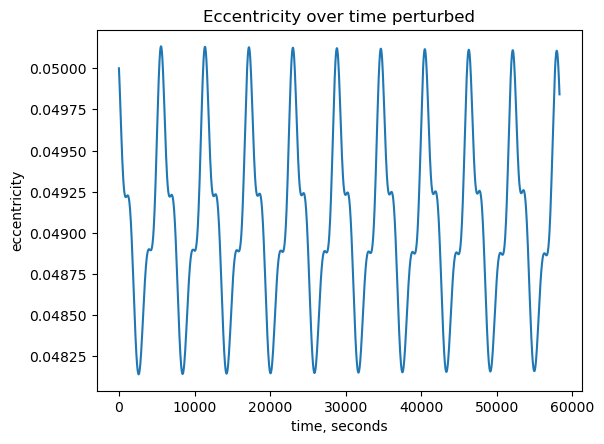

In [117]:
plt.plot(t_actual,e_list)
plt.xlabel("time, seconds")
plt.ylabel("eccentricity")
plt.title("Eccentricity over time perturbed")
plt.tight_layout(pad=2.0)
plt.savefig("hw4_1_12_e.jpg", dpi = 300)
plt.show()

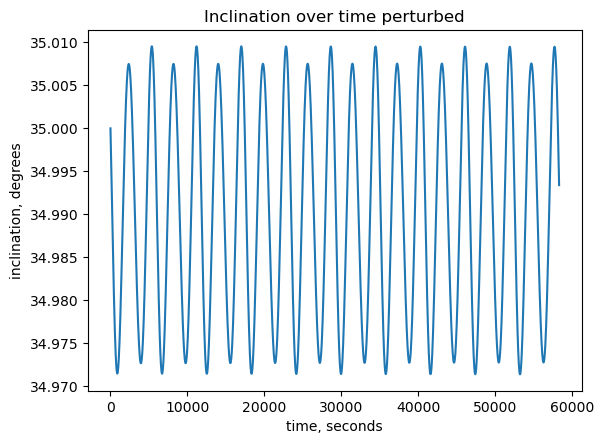

In [118]:
plt.plot(t_actual,np.rad2deg(i_list))
plt.xlabel("time, seconds")
plt.ylabel("inclination, degrees")
plt.title("Inclination over time perturbed")
plt.tight_layout(pad=2.0)
plt.savefig("hw4_1_12_i.jpg", dpi = 300)
plt.show()

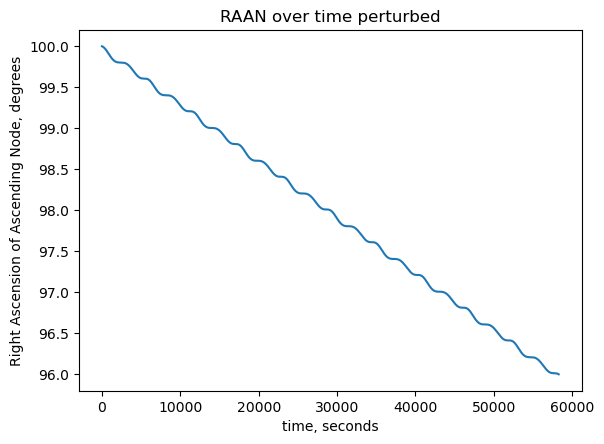

In [119]:
plt.plot(t_actual,np.rad2deg(omega_list))
plt.xlabel("time, seconds")
plt.ylabel("Right Ascension of Ascending Node, degrees")
plt.title("RAAN over time perturbed")
plt.tight_layout(pad=2.0)
plt.savefig("hw4_1_12_omega.jpg", dpi = 300)
plt.show()

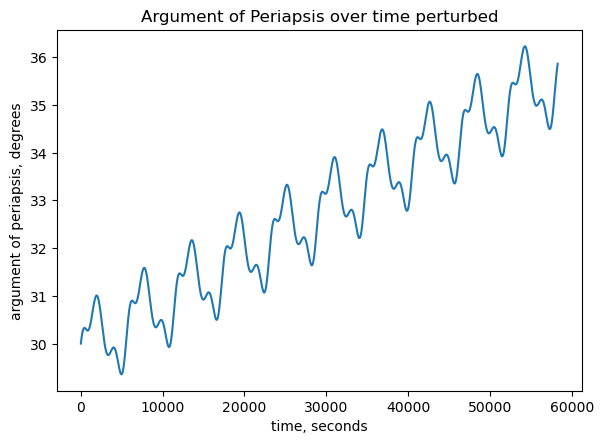

In [120]:
plt.plot(t_actual,np.rad2deg(w_list))
plt.xlabel("time, seconds")
plt.ylabel("argument of periapsis, degrees")
plt.title("Argument of Periapsis over time perturbed")
plt.tight_layout(pad=2.0)
plt.savefig("hw4_1_12_w.jpg", dpi = 300)
plt.show()

# 4 credit hr question:

sun-synchronous orbit (pass over same point at same time each day)

google says 98 to 99 degrees

In [18]:
#might as well calculate it to be sure
#from wikipedia: https://en.wikipedia.org/wiki/Sun-synchronous_orbit
rho = (np.pi/180)/86400 #d(RAAN)/dt
#may need to divide by 365
i = np.arccos(-(2*rho)/(3*J2*R**2*np.sqrt(mu))*a**(7/2))
print(f"For this orbit with a = {a} km, inclination for precession at 1 deg per day i = {np.degrees(i)} deg")

For this orbit with a = 7000.0 km, inclination for precession at 1 deg per day i = 97.98966937492979 deg


## Question 2: Gauss IOD

In [169]:
#copied most of this directly from lecture 23's matlab code
t_list = np.array([0,118.10,237.58])
raan_list = np.array([np.radians(43.537),np.radians(54.420),np.radians(64.318)])
declination_list = np.array([np.radians(-8.7883), np.radians(-12.074), np.radians(-15.105)])
R1 = np.array([3489.83, 3430.17, 4078.54])
R2 = np.array([3460.13, 3460.13, 4078.54])
R3 = np.array([3429.86, 3490.13, 4078.54])

def rho_hat_finder(alpha,delta):
    rh_i = np.cos(delta)*np.cos(alpha)
    rh_j = np.cos(delta)*np.sin(alpha)
    return np.array([rh_i,rh_j,np.sin(delta)])

rho1_hat = rho_hat_finder(raan_list[0],declination_list[0])
rho2_hat = rho_hat_finder(raan_list[1],declination_list[1])
rho3_hat = rho_hat_finder(raan_list[2],declination_list[2])
print(f"rho1_hat = {rho1_hat}")
print(f"rho2_hat = {rho2_hat}")
print(f"rho3_hat = {rho3_hat}")

p1 = np.cross(rho2_hat,rho3_hat)
p2 = np.cross(rho1_hat,rho3_hat)
p3 = np.cross(rho1_hat,rho2_hat)

D0 = np.dot(rho1_hat,p1)
print(f"D0 = {D0}")

tau1 = t_list[0]-t_list[1]
tau3 = t_list[2]-t_list[1]
tau = tau3 - tau1
# print(tau1,tau3,tau)
D11 = np.dot(R1,p1)
D12 = np.dot(R1,p2)
D13 = np.dot(R1,p3)
D21 = np.dot(R2,p1)
D22 = np.dot(R2,p2)
D23 = np.dot(R2,p3)
D31 = np.dot(R3,p1)
D32 = np.dot(R3,p2)
D33 = np.dot(R3,p3)
A = 1/D0*(-D12*tau3/tau + D22 + D32*tau1/tau)
B = 1/6/D0*(D12*(tau3**2 - tau**2)*tau3/tau + D32*(tau**2 - tau1**2)*tau1/tau)
E = np.dot(R2,rho2_hat)
# print(A,B,E)
R2sq = np.dot(R2,R2)
a = -(A**2 + 2*A*E + R2sq)
b = -2*mu*B*(A+E)
c = -mu**2 * B**2
# print(a,b,c)
x = np.roots([1., 0, a, 0, 0, b, 0, 0, c])
r2_mag = 0.
# print(x)
for i in range(len(x)):
    if np.isreal(x[i]) & (x[i] > 0):
        r2_mag = x[i].real
# print(r2_mag)
rho1 = 1/D0*((6*(D31*tau1/tau3+D21*tau/tau3)*r2_mag**3 + mu*D31*(tau**2-tau1**2)*tau1/tau3)/(6*r2_mag**3 + mu*(tau**2 - tau3**2)) - D11);
rho2 = A+mu*B/r2_mag**3
rho3 = 1/D0*((6*(D13*tau3/tau1-D23*tau/tau1)*r2_mag**3 + mu*D13*(tau**2-tau1**2)*tau3/tau1)/(6*r2_mag**3 + mu*(tau**2 - tau1**2)) - D33)
print(f"rho1: {rho1}")
print(f"rho2: {rho2}")
print(f"rho3: {rho3}")

r1 = R1 + rho1*rho1_hat
r2 = R2 + rho2*rho2_hat #position as sighted at r2?
r3 = R3 + rho3*rho3_hat
f1 = 1 - 1/2*mu/r2_mag**3 * tau1**2
g1 = tau1-1/6*mu/r2_mag**3 * tau1**3
f3 = 1 - 1/2*mu/r2_mag**3 * tau3**2
g3 = tau3 - 1/6*mu/r2_mag**3 * tau3**3
v2 = 1/(f1*g3 - f3*g1)*(-f3*r1 + f1*r3)
print(f"r2 = {r2}")
print(f"v2 = {v2}")

rho1_hat = [ 0.71641874  0.6807358  -0.15278403]
rho2_hat = [ 0.56896781  0.79531221 -0.20917484]
rho3_hat = [ 0.4184028   0.8700762  -0.26058876]
D0 = -0.0015321902871423994
rho1: 3622.9875928873466
rho2: 3848.4430843078353
rho3: 4171.666859665283
r2 = [5649.7702502  6520.84378002 3273.54254368]
v2 = [-3.83334281  5.15756953 -2.2473264 ]


In [175]:
#find orbital elements
mu = 398600.
a_2,e_2,i_2,omega_2,w_2, f_2 = cartesian_to_elements(r2,v2,mu)
print(f"semimajor axis = {a_2} km")
print(f"eccentricity = {e_2}")
print(f"inclination = {np.degrees(i_2)} deg")
print(f"RAAN = {np.degrees(omega_2)} deg")
print(f"Argument of periapsis = {np.degrees(w_2)} deg")
print(f"True anomaly = {np.degrees(f_2)} deg")

semimajor axis = 9954.293837214487 km
eccentricity = 0.10342160428942775
inclination = 30.224184903451267 deg
RAAN = 269.73064183830945 deg
Argument of periapsis = 85.68839871074944 deg
True anomaly = 49.50595785325575 deg


## Question 3: ILOVE370ILOVE370ILOVE370ILOVE370

god I love numerical methods

actually it was fine lol

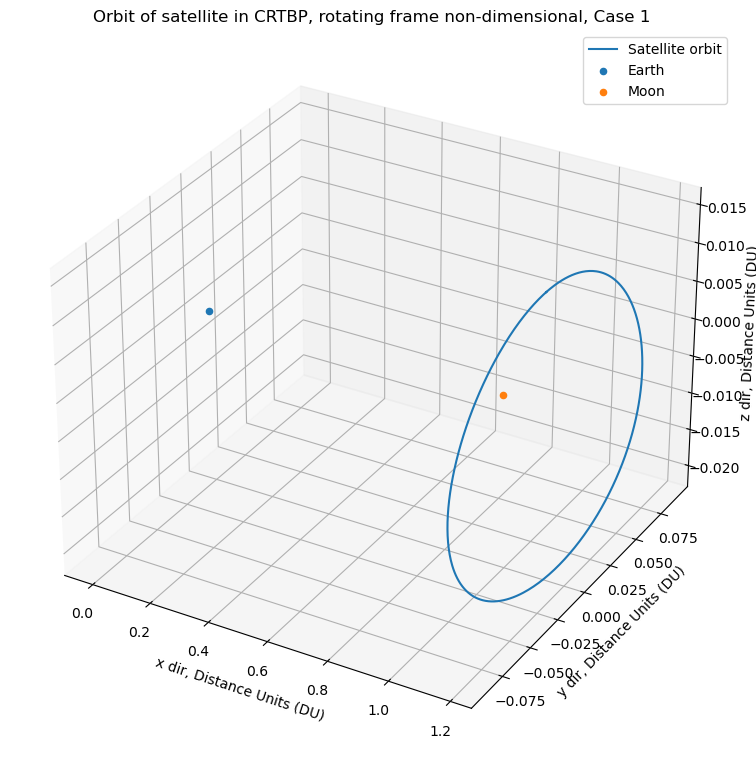

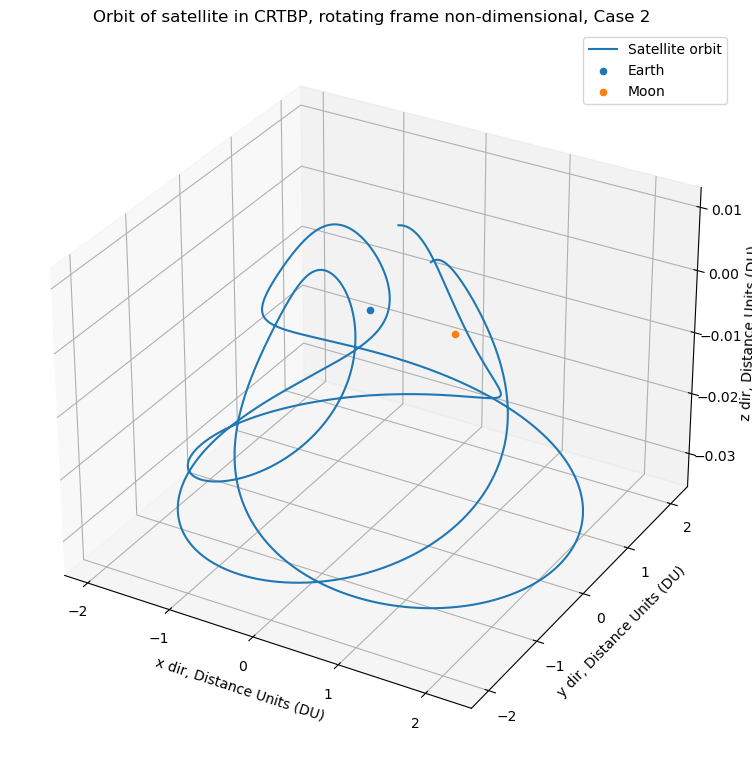

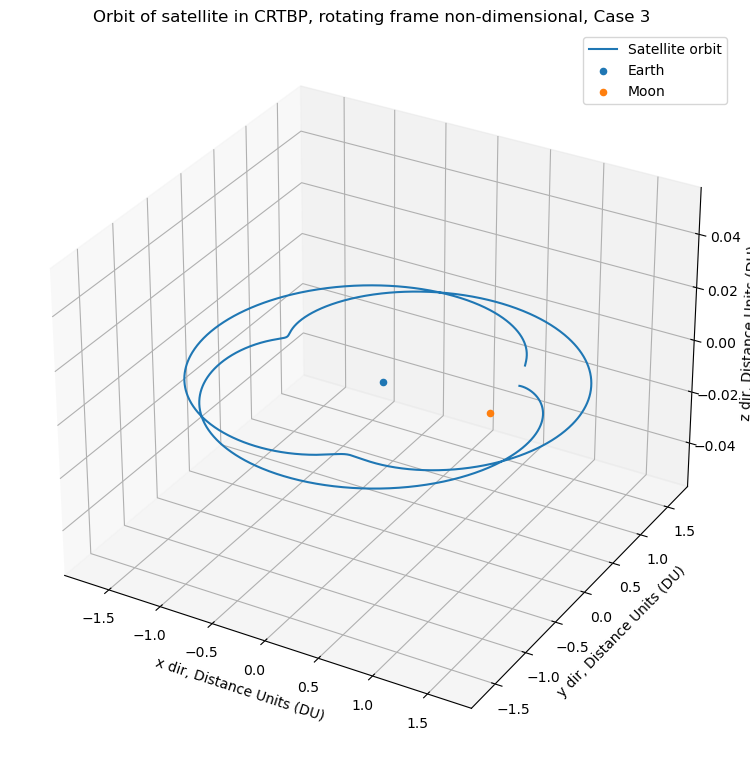

In [21]:
#need to linearize into 1st order equations

#### actually, can we just use IVP from question 1 with no perturbation since it only gives r0 and v0...
#### it only gives info for 1 body, where is the second body...
#actually Prof confirmed the bodies are fixed in rotating frame. are we graphing in rotating frame? if so do we need to show the bodies...
#need to develop function

mu_list = np.array([0.012150585609262, 0.012150585609262, 0.012150585609262])
r0_list = np.array([[1.118824389202157,0.0,0.014654873101278], [0.7, 0.0, 0.01], [1-mu_list[2], 0.5, 0.0]])
v0_list = np.array([[0.0,0.180568501159703,0.0], [0.0, 0.8, 0.0], [-1.0e-15, 0.0, 0.0]])
t_list = np.array([3.4121381127321, 30., 30.])
#I would use solve_ivp

def denom(x,y,z,xi):
    """
    too lazy to do denominator calcs lol
    """
    return ((x-xi)**2 + y**2 + z**2)**(3/2)

def eom_CRTBP(t,u, mu, x1, x2):
    """
    takes in state u and mu, outputs u_dot
    x1, x2 are already found
    """
    udot = np.zeros_like(u) #v, a
    r_eom = u[0:3]
    r_mag_eom = np.linalg.norm(r_eom)
    x_e = r_eom[0]
    y_e = r_eom[1]
    z_e = r_eom[2]
    dU_dx = x_e - ((1-mu)*(x_e-x1))/denom(x_e,y_e,z_e,x1) - (mu*(x_e-x2))/denom(x_e,y_e,z_e,x2)
    dU_dy = y_e - ((1-mu)*y_e)/denom(x_e,y_e,z_e,x1) - (mu*y_e)/denom(x_e,y_e,z_e,x2)
    dU_dz = -((1-mu)*z_e)/denom(x_e,y_e,z_e,x1) - (mu*z_e)/denom(x_e,y_e,z_e,x2)
    udot[0:3] = u[3:6] #lazy, just do this
    udot[3] = 2*u[4] + dU_dx
    udot[4] = -2*u[3] + dU_dy
    udot[5] = dU_dz
    return udot

def CRTBP_solver(t,r0,v0,mu_i):
    x1 = -mu_i
    x2 = 1-mu_i
    t_span = (0.0, t)
    # t = np.arange(0.0, T*10., 0.1) #dt = 1 second
    # print(np.append(r0,v0))
    solution = sp.integrate.solve_ivp(eom_CRTBP, t_span, np.append(r0,v0), args=(mu_i, x1, x2), method='RK45', rtol=1e-13, atol = 1e-13)
    u = solution.y
    t_actual = solution.t
    return u, t_actual, x1, x2

for i in range(len(mu_list)):
    u_i,t_i, x1_i, x2_i = CRTBP_solver(t_list[i], r0_list[i], v0_list[i], mu_list[i])
    fig = plt.figure(figsize=(10,8)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot(u_i[0],u_i[1],u_i[2], label = "Satellite orbit")
    ax.scatter3D(x1_i,0,0, label = "Earth")
    ax.scatter3D(x2_i,0,0, label = "Moon")
    ax.set_xlabel("x dir, Distance Units (DU)")
    ax.set_ylabel("y dir, Distance Units (DU)")
    ax.set_zlabel("z dir, Distance Units (DU)")
    ax.legend()
    ax.set_title(f"Orbit of satellite in CRTBP, rotating frame non-dimensional, Case {i+1}")
    fig.tight_layout(pad=2.0)
    plt.savefig(f"hw4_3_case_{i+1}.jpg", dpi = 300)
    plt.show()